# Problem Statement

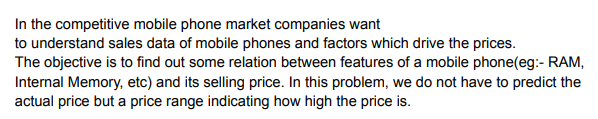

**This will basically help companies to estimate price of mobiles to give tough competition to other mobile manufacturer.
Also, it will be useful for consumers to verify that they are paying best price for a mobile**

Data Fields:

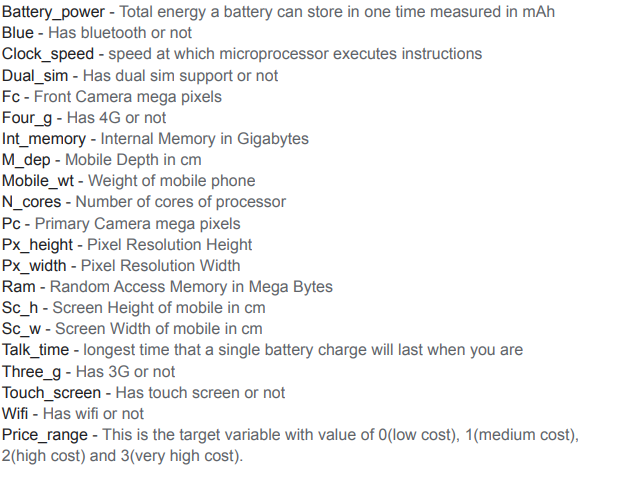

# Data Exploration


Some distribution tables are created in excel and snapshots are attached here.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
%%capture
! pip install shap

In [ ]:
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# loading the Dataset
path = '/content/drive/MyDrive/Cohort Nilgiri/Module 4/Capstone Project 3/data.csv'

df = pd.read_csv(path)

df.head()

In [ ]:
# have a look at the columns
columns = df.columns

columns

## Handling discrepancy in data

In [ ]:
df.describe().T

From the above description, I can see the minnimum value for columns 'sc_w' (screen width) and for 'px_height' is 0, which is not possible in real life. We need handle these discrepencies in data and will have to replace these values.

In [ ]:
# check in how many rows 'sc_w' is 0
df[df['sc_w']==0].shape[0]

In [ ]:
# relation between sc_h and sc_w

sns.scatterplot(df[df['sc_w']!=0]['sc_h'], df[df['sc_w']!=0]['sc_w'])
plt.show()

As we can see in the above plot, for each value of 'sc_h' there are multiple values of 'sc_w', so our best shot for guessing the values of the 'sc_w' would be taking an aggegate of all available values 'sc_w' for all values of 'sc_h'.

In [ ]:
srs = df[df['sc_w']!=0].groupby(by='sc_h')['sc_w'].mean()
srs

In [ ]:
import math

In [ ]:
d = {key:math.ceil(value) for key,value in zip(srs.index, srs.values)}

In [ ]:
sc_h = list(df['sc_h'])
sc_w = list(df['sc_w'])

for i in range(len(sc_w)):
    if sc_w[i] == 0:
        sc_w[i] = d[sc_h[i]]

df['sc_h'] = sc_h
df['sc_w'] = sc_w

In [ ]:
# now check the rows with 'sc_w'=0
df[df['sc_w']==0].shape[0]

Converting columns 'sc_h' and 'sc_w' in a single column screen_size , it will be the vertical length of the mobile.

In [ ]:
df['screen_size'] = ((df['sc_h']**2)+(df['sc_w']**2))**0.5

df.drop(['sc_h','sc_w'], axis=1 ,inplace=True)

In [ ]:
df.columns

Now let's deal with the zeros in 'px_height' column.

In [ ]:
# there are only two observations where 'px_height' in 0
df[df['px_height']==0]

Only two rows are showing discrepancy in 'px_heigh', but we'll be using the similar method for this too.

In [ ]:
sns.scatterplot(df[df['px_height']!=0]['px_width'], df[df['px_height']!=0]['px_height'])
plt.show()

Let's try linear regression to get this done.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

model.fit(df[df['px_height']!=0].loc[:,['px_width']], df[df['px_height']!=0]['px_height'])

In [ ]:
model.predict(df[df['px_height']==0].loc[:,['px_width']])

In [ ]:
df[df['px_height']==0].index

In [ ]:
# fixing the values
for i, value in zip(df[df['px_height']==0].index, model.predict(df[df['px_height']==0].loc[:,['px_width']])):
    df.at[i,'px_height'] = int(value)

In [ ]:
df[df['px_height']==0].shape
# zero rows we have now

Let's analyze the features value distribution for each target class.

In [ ]:
# categorical and continuous separation

categoricals = [ 'blue',  'dual_sim',  'four_g',
         'three_g', 'touch_screen', 'wifi', 'n_cores']

continuous = ['battery_power','clock_speed','fc','int_memory','m_dep', 'mobile_wt', 'pc', 'px_height',
       'px_width', 'ram', 'talk_time','screen_size']

Let's analyze the features value distribution for each target class.

## Categorical analysis

In [ ]:
fig, axs = plt.subplots(1, len(categoricals), figsize=(21,4))

for i in range(len(categoricals)):
    sns.countplot(x=df[categoricals[i]], ax=axs[i])
    axs[i].set_ylabel('')

As we can see in the plot above, except 'three_g' and 'n_cores' feature, almost all of them have equal distribution of both categories, three_g can play an important role in prediction.

In [ ]:
# function to plot the distribution of categorical feature
# for each price range category
def plot_along_taget(column_name):
    fig, axs = plt.subplots(1,4, figsize=(16, 4))
    for i in range(4):
        sns.countplot(x=df[df['price_range']==i][column_name] , ax=axs[i])
        axs[i].set_xlabel(f'{column_name} category')
        axs[i].set_title(f'for price_range = {i}')

Now let us see the categorical variables distribution along the different categories of target variable 'price_range'

### Bluetooth

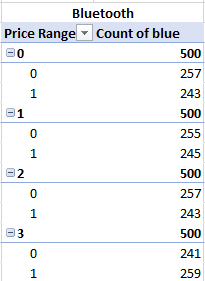

The availability of bluetooth is almost same for every price range as you can see in the above table,let's validate it with the graph.

In [ ]:
plot_along_taget('blue')

The bluetooth distribution doesn't really varies much from one price_range to another. They all have almost half observations with bluetooth.

### Dual Sim

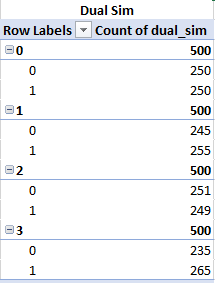

The dual_sim feature is present in half of the observations in each cateory as we can see above table. Let's validate it by graph.

In [ ]:
plot_along_taget('dual_sim')

The dual_sim feature distributions shows a little pattern for only price_category 3. For rest of them it has half half distribution.

### 4G

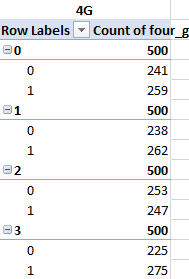

The availability of 4G sim feature also shows similar distribution for each class except price_range 3.

In [ ]:
plot_along_taget('four_g')

The graph also shows the same thing. For price range 3 we have more observations with 4G availability.

### 3G

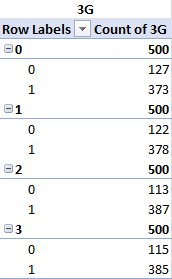

In [ ]:
plot_along_taget('three_g')

The availability of 3G shows quite similar distribution for each price range, which doesn't look good for predictions.

### 4G and 3G feature analysis

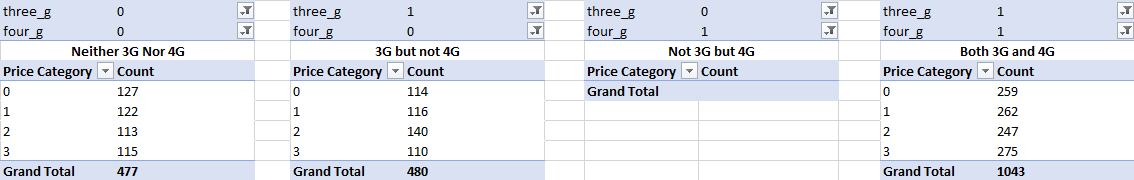

In the above tables, we can look at the combination of feature 3G and 4G. Interestingly, we can observe(look at the third table from left) that there are zero number of mobile phones that supports 4G but not 3G. That means every phone that supports 4G, will support 3G by default.

So, I'm gonna make a single feature called 'network' out of 3G and 4G features.

In [ ]:
df['network'] = df['four_g'] + df['three_g']

In this new feature 'network', there will be three categories:


*   0 : Supports neither of 3G or 4G
*   1 : Supports 3G but not 4G
*   2 : Supports both 3G and 4G



In [ ]:
# drop the 3G and 4G columns
df.drop(['four_g', 'three_g'], inplace=True, axis=1)

In [ ]:
categoricals.remove('four_g')
categoricals.remove('three_g')

In [ ]:
# analyze the distribution of network along target variable
plot_along_taget('network')

The new feature 'network' also does not show much variation along the price ranges. But using it instead of 3G and 4G both will help to reduce the complexity of the problem and makes the models more interpretable.

### Touch Screen

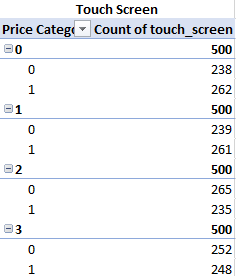

In [ ]:
plot_along_taget('touch_screen')

Touch screen feature shows very little variation along the different price categories, which won't help much in price range prediction.

### WiFi

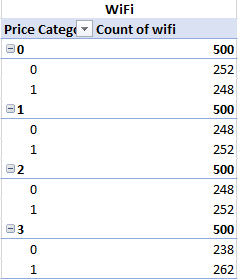

In [ ]:
plot_along_taget('wifi')

The wifi feature shows quite similar features except for the price_range 3.

### n_cores

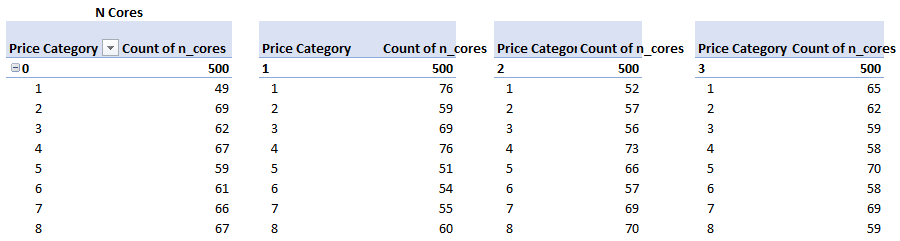

In [ ]:
plot_along_taget('n_cores')

number of cores in mobile shows some interesting patterns for different price ranges. It can be a helpful factor for price range prediction.

## Continuous variables analysis

In [ ]:
df[continuous].head()

Let's convert screen_size from cm to inches, since in real life we use inches to tell a screen size.

In [ ]:
df['screen_size'] = df['screen_size']/2.54

Also converting RAM unit from Megabytes to Gigabytes, since we are more usual to Gigabytes.

In [ ]:
df['ram'] = df['ram']/1024

In [ ]:
sns.set_style('darkgrid')

### Battery Power

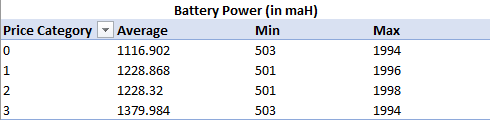

Here we're using density plot (in the left), which is a variation of histogram to viualize the distribution of a continuous variable along the categories of target variable. On the right side we're using boxplot.

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='battery_power', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='battery_power', ax=axs[1])
plt.show()

Here we can notice clear distribution difference for price_range-0 and price_range-3.


*   Mobiles in price_range-0 mostly have lower battery power.
*   Mobiles in price_range-3 mostly have higher battery power.
*   Mobiles in price_range-1 and price_range-2 also showing some variation in distribtion.

Based on these observations, we can conclude that this feature would be importand for predicting price_range.



### Clock Speed

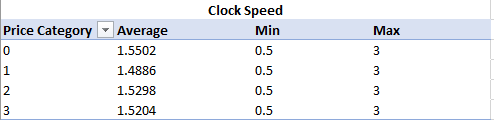

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='clock_speed', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='clock_speed', ax=axs[1])
plt.show()

The Clock Speed distribution is very similar along all the price ranges except 0 , which is a little different.

### FC (front camera megapixels)

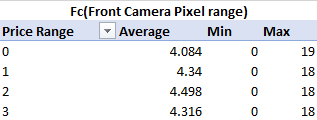

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='fc', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='fc', ax=axs[1])
plt.show()

This features distribution is almost similar along all the price ranges variable, it may not be helpful in making predictions.

Some outliers can also be seen here, we'll deal with them in a different section.

### Internal Memory

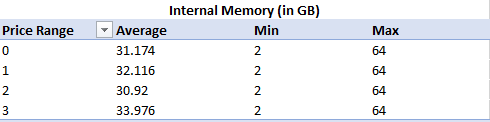

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='int_memory', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='int_memory', ax=axs[1])
plt.show()

There is a little variation in the Internal Memory along the Price range. Mobiles with higher price seems to have higher internal memory. This feature could be helpful in predicting the Price range.

### Mobile Depth

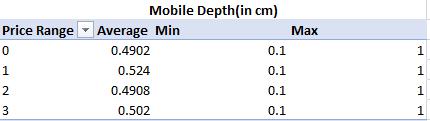

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='m_dep', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='m_dep', ax=axs[1])
plt.show()

Mobile depth again has somewhat similar kind of distribution along all the price_ranges. Just a little variation can be seen in the boxplot. It's not gonna be a very important factor for deciding price.

### Mobile Weight

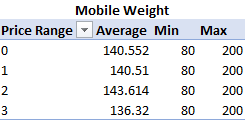

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='mobile_wt', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='mobile_wt', ax=axs[1])
plt.show()

Mobile weight is reduced a little bit in the Price category-3 which means costly phones are ligher. A little variation is observed here in all price_ranges.

### PC (Primary camera Megapixels)

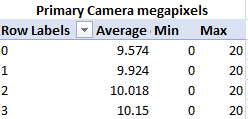

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='n_cores', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='n_cores', ax=axs[1])
plt.show()

Primary camera megapixels are showing a little variation along the target categories, which is a good sign for prediction.

### Screen Size (Vertical length in pixels)

This is a feature that was not given in the dataset and was generated manually with the help of two features screen_height and screen_width. Instead of Screen height and width, we can keep this feature in the dataset to handle multicollinearity.

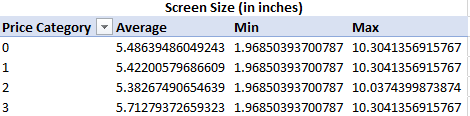

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='screen_size', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='screen_size', ax=axs[1])
plt.show()

Screen Size shows very little variation along the target variables. This would not be an important feature for predicting the target categories.

### px_height (Pixel Resolution Height)

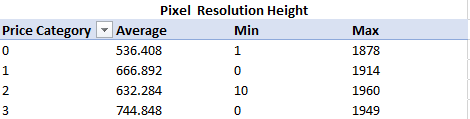

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='px_height', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='px_height', ax=axs[1])
plt.show()

A little variation is there in px_height.

### px_width (Pixel resolution width)

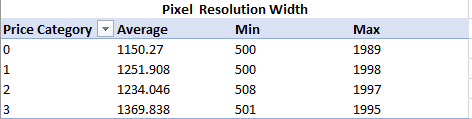

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='px_width', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='px_width', ax=axs[1])
plt.show()

Some variation is visible here in px_width as well, so we can say that it would be a driving factor in deciding price_range.

### RAM (in GB)

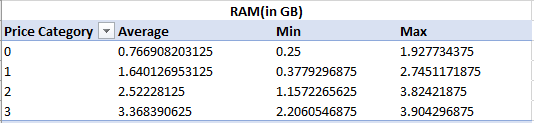

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='ram', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='ram', ax=axs[1])
plt.show()

RAM is showing a great variation in the distribution along the target variable. Which is a good sign for making predictions. RAM is gonna be a driving factor for predicting price_range.

### n_cores

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='n_cores', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='n_cores', ax=axs[1])
plt.show()

Here also n_cores is showing interesting patterns. It may be useful in predictions.

### Talk Time (in Hours)

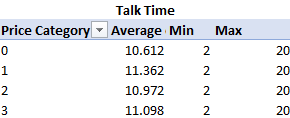

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='n_cores', hue='price_range', ax=axs[0])
sns.boxplot(data=df, x='price_range', y='n_cores', ax=axs[1])
plt.show()

A little variation is visible in talk time along the price_ranges.

### Checking colinearity in continuous variables

In [ ]:
corr = df[continuous].corr()

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)
plt.show()

There is some colinearity in feature pairs ('pc', 'fc') and ('px_width', 'px_height'). Both correlations are justified since there are good chances that if front camera of a phone is good, the back camera would also be good.

Also if px_height increases, pixel width also increases, that means the overall pixels in the screen. We can replace these two features with one feature.

In [ ]:
# make single feature out of px_height and px_width.
df['pixels'] = df['px_height']*df['px_width']

In [ ]:
continuous.append('pixels')

We can drop the px_height and px_width column now.

In [ ]:
df.drop(['px_height', 'px_width'], axis=1, inplace=True)

In [ ]:
continuous.remove('px_height')
continuous.remove('px_width')

In [ ]:
# let's check the colinearity again
corr = df[continuous].corr()

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)
plt.show()

Front Camera megapixels and Primary camera megapixels are different entities despite of showing colinearity. So we'll be keeping them as they are.

# Outlier Analysis

Let's check if we have any outliers in our continuous variables.

In [ ]:
continuous

In [ ]:
df['pixels2'] = df['pixels']**0.5
continuous.append('pixels2')

In [ ]:
len(continuous)

In [ ]:
fig, axs = plt.subplots(2,6, figsize=(20,10))

for i in range(len(continuous)):
    sns.boxplot(y =df[continuous[i]], ax=axs[i//6][i%6])
    axs[i//6][i%6].set_xlabel(continuous[i])
    axs[i//6][i%6].set_ylabel('')

plt.show()

As we can see in the 'pixels' column that we have significant number of outliers, but in squared root column of 'pixel2' outliers are removed. So we are going to used only square root version of that.

In [ ]:
df['pixels'] = df['pixels']**0.5
df.drop('pixels2',axis=1,inplace=True)

In [ ]:
sns.boxplot(y =df['pixels'] )

See! No outliers now.

# Predictive Modelling

We tried various models and including the models that worked best for us here.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
%matplotlib inline

Before moving forward with the predictive modelling, let's summarise all preprocessin in one function, so we can start right from this point the next time we open notebook.

In [ ]:
def pre_process():
    df = pd.read_csv('/content/drive/MyDrive/Cohort Nilgiri/Module 4/Capstone Project 3/data.csv')

    # replace 180 zeros in 'sc_w' column
    srs = df[df['sc_w']!=0].groupby(by='sc_h')['sc_w'].mean()
    d = {key:math.ceil(value) for key,value in zip(srs.index, srs.values)}

    sc_h = list(df['sc_h'])
    sc_w = list(df['sc_w'])

    for i in range(len(sc_w)):
        if sc_w[i] == 0:
            sc_w[i] = d[sc_h[i]]

    df['sc_h'] = sc_h
    df['sc_w'] = sc_w

    # replace 2 zeros in 'pixel_h' column
    model = LinearRegression()
    model.fit(df[df['px_height']!=0].loc[:,['px_width']], df[df['px_height']!=0]['px_height'])

    for i, value in zip(df[df['px_height']==0].index, model.predict(df[df['px_height']==0].loc[:,['px_width']])):
        df.at[i,'px_height'] = int(value)

    # creating single column 'screen_size' out of 'sc_h' and 'sc_w'
    df['screen_size'] = ((df['sc_h']**2)+(df['sc_w']**2))**0.5
    df.drop(['sc_h','sc_w'], axis=1 ,inplace=True)

    # creating single columns out of 'four_g' and 'three_g'
    df['network'] = df['four_g'] + df['three_g']
    df.drop(['four_g', 'three_g'], axis=1 ,inplace=True)

    # creating single column out of 'px_height' and 'px_width'
    df['pixels'] = (df['px_height']*df['px_width'])**0.5
    df.drop(['px_height','px_width'], axis=1 ,inplace=True)

    X = df.drop('price_range', axis=1)
    y = df['price_range']

    return X,y

In [ ]:
X,y = pre_process()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
import shap

Since the dataset is perfectly balanced for each class, I wrote a custom train_test_split function, that returns the perfectly balanced train_set and test_set.

In [ ]:
# since the dataset is perfectly balanced
# we want the test set and train set also to be
# balanced perfectly
def train_test_split(X, y, test_size=.10, random_state=42):
    # list of indexes of the observations
    # in the test set and train set
    train_indexes = []
    test_indexes = []
    
    np.random.seed(random_state)
    
    # for each category of target variable
    for i in np.unique(y):
        indices = np.where(y==i)[0]
        test = np.random.choice(indices, size=int(len(indices)*test_size), replace=False)
        train = list(set(indices) - set(test))
        #train = [ind for ind in indices if ind not in test]
        train_indexes.extend(train)
        test_indexes.extend(test)
    
    X_train = np.take(a=X, indices=train_indexes, axis=0)
    X_test = np.take(a=X, indices=test_indexes, axis=0)
    y_train = np.take(a=y, indices=train_indexes, axis=0)
    y_test = np.take(a=y, indices=test_indexes, axis=0)
    
    return(X_train, X_test, y_train, y_test)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clsr = DecisionTreeClassifier()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# check frequency of each class in test set
np.unique(y_test, return_counts=True)

In [ ]:
clsr.fit(X_train, y_train)

In [ ]:
y_pred = clsr.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
class_names = ['low cost','medium cost', 'high cost', 'very high cost']

In [ ]:
plot_confusion_matrix(clsr, X_test, y_test, cmap=plt.cm.Blues, display_labels=class_names, xticks_rotation='vertical')
plt.show()

Have a look at the feature importances according to decision tree model

In [ ]:
feature_importance = pd.DataFrame({'Feature':X.columns,
                                   'Score':clsr.feature_importances_}).sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
feature_importance.head()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x=feature_importance['Score'], y=feature_importance['Feature'])
plt.show()

In [ ]:
X_shap=X_train
explainer = shap.TreeExplainer(clsr)
shap_values = explainer.shap_values(X_shap)

In [ ]:
shap.summary_plot(shap_values[1], X_shap, plot_type="dot")

### Visualizing the tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [ ]:
graph = Source(tree.export_graphviz(clsr, out_file=None
   , feature_names=X.columns, class_names=['0', '1', '2', '3'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X,y = pre_process()
X_train, X_test, y_train, y_test = train_test_split(X,y,.20,42)

In [ ]:
# taking 300 trees
clsr = RandomForestClassifier(n_estimators=300)

In [ ]:
clsr.fit(X_train, y_train)

In [ ]:
y_pred = clsr.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

Accuracy jumped to 88% from 83% when random forest is used.

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(clsr, X_test, y_test, cmap=plt.cm.Blues, display_labels=class_names, xticks_rotation='vertical')
plt.show()

Let's get the important features for random forest.

In [ ]:
feature_importance = pd.DataFrame({'Feature':X.columns,
                                   'Score':clsr.feature_importances_}).sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
feature_importance.head()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x=feature_importance['Score'], y=feature_importance['Feature'])
plt.show()

In [ ]:
X_shap=X_train
explainer = shap.TreeExplainer(clsr)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values[1], X_shap, plot_type="dot")

RAM is certainly the most important feature for prediction of Price Range.

Now let's try to detect the best set of features for predictions.

In [ ]:
# here I'll run the RF classifier on most important feature
# and will keep adding the next most important fature
# we'll keep record of the accuracy
# this way we'll be able to Identify which feature works best for us
features = []
accuracy = []
report = []

for i in range(feature_importance.shape[0]):
    
    X1 = X[list(feature_importance.Feature[:i+1])]
    
    X_train, X_test, y_train, y_test = train_test_split(X1,y,.20, 42)
    
    clsr = RandomForestClassifier(n_estimators=300, random_state=42)
    
    clsr.fit(X_train, y_train)
    
    y_pred = clsr.predict(X_test)
    
    features.append(list(feature_importance.Feature[:i+1]))
    accuracy.append(accuracy_score(y_test, y_pred))
    report.append(classification_report(y_test, y_pred))

In [ ]:
ftrs_report = pd.DataFrame({'Feature List':features, 'Accuracy':accuracy, 'Report':report}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

In [ ]:
ftrs_report.head()

Let's check out the top features set which gave 92% accuracy.

In [ ]:
ftrs_report['Feature List'][0]

In [ ]:
print(ftrs_report['Report'][0])

So, now we have our best features set. We'll use them only. Let's try to get more accuracy by applying Hyper-parameter tuning.

In [ ]:
X = X[ftrs_report['Feature List'][0]]

### Hyperparameter tuning for Random Forest

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'n_estimators':[300,500,700],
          'max_depth':[None,10,20,30,40],
          'min_samples_split':[2,6],
          'max_leaf_nodes':[None, 20, 40]
          }

In [ ]:
rf = RandomForestClassifier()
clsr = GridSearchCV(rf, params, scoring='accuracy', cv=5)
clsr.fit(X, y)

In [ ]:
clsr.best_params_

In [ ]:
clsr.best_estimator_

In [ ]:
clsr.best_score_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
clsr = clsr.best_estimator_

In [ ]:
clsr.fit(X_train, y_train)

In [ ]:
y_pred = clsr.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

We are getting almost 93% accuracy with Random Forest model.

## Adaboost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X,y = pre_process()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,.20,42)

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
clsr = AdaBoostClassifier(n_estimators=300, base_estimator=dt,learning_rate=1,)

In [ ]:
clsr.fit(X_train, y_train)

In [ ]:
y_pred = clsr.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(clsr, X_test, y_test, cmap=plt.cm.Blues, display_labels=class_names, xticks_rotation='vertical')
plt.show()

In [ ]:
feature_importance = pd.DataFrame({'Feature':X.columns,
                                   'Score':clsr.feature_importances_}).sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
feature_importance.head()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x=feature_importance['Score'], y=feature_importance['Feature'])
plt.show()

In [ ]:
# here I'll run the Adaboost classifier on most important feature
# and will keep adding the next most important fature
# we'll keep record of the accuracy
# this way we'll be able to Identify which feature works best for us
features = []
accuracy = []
report = []

for i in range(feature_importance.shape[0]):
    
    X1 = X[list(feature_importance.Feature[:i+1])]
    
    X_train, X_test, y_train, y_test = train_test_split(X1,y,.20, 42)
    
    clsr = AdaBoostClassifier(n_estimators=300, base_estimator=dt,learning_rate=1,)
    
    clsr.fit(X_train, y_train)
    
    y_pred = clsr.predict(X_test)
    
    features.append(list(feature_importance.Feature[:i+1]))
    accuracy.append(accuracy_score(y_test, y_pred))
    report.append(classification_report(y_test, y_pred))

In [ ]:
ftrs_report = pd.DataFrame({'Feature List':features, 'Accuracy':accuracy, 'Report':report}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

In [ ]:
ftrs_report.head()

In [ ]:
X = X[['ram', 'battery_power', 'pixels']]

### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,.2,42)

In [ ]:
dt1 = DecisionTreeClassifier(max_depth=10)
dt2 = DecisionTreeClassifier(max_depth=20)
dt3 = DecisionTreeClassifier(max_depth=30)

In [ ]:
params = {'n_estimators':[100,300,1000],
          'learning_rate':[0.001, 0.01, 0.1, 1],
          'base_estimator':[None, dt1, dt2, dt3]}

In [ ]:
adaboost = AdaBoostClassifier()
clsr = GridSearchCV(estimator=adaboost, param_grid=params, scoring='accuracy', cv=5)
clsr.fit(X, y)

In [ ]:
clsr.best_params_

In [ ]:
y_pred = clsr.best_estimator_.fit(X_train, y_train).predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

We are getting around 92% accuracy with AdaBoost Classifer.

In [ ]:
plot_confusion_matrix(clsr.best_estimator_, X_test, y_test, cmap=plt.cm.Blues, display_labels=class_names, xticks_rotation='vertical')
plt.show()

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
X,y = pre_process()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,.20,42)

In [ ]:
clsr = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=1)

In [ ]:
clsr.fit(X_train, y_train)

In [ ]:
y_pred = clsr.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(clsr, X_test, y_test, cmap=plt.cm.Blues, display_labels=class_names, xticks_rotation='vertical')
plt.show()

In [ ]:
feature_importance = pd.DataFrame({'Feature':X.columns,
                                   'Score':clsr.feature_importances_}).sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
feature_importance.head()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x=feature_importance['Score'], y=feature_importance['Feature'])
plt.show()

In [ ]:
# here I'll run the Gradient Boosting classifier on most important feature
# and will keep adding the next most important fature
# we'll keep record of the accuracy
# this way we'll be able to Identify which feature works best for us
features = []
accuracy = []
report = []

for i in range(feature_importance.shape[0]):
    
    X1 = X[list(feature_importance.Feature[:i+1])]
    
    X_train, X_test, y_train, y_test = train_test_split(X1,y,.20, 42)
    
    clsr = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=1)
    
    clsr.fit(X_train, y_train)
    
    y_pred = clsr.predict(X_test)
    
    features.append(list(feature_importance.Feature[:i+1]))
    accuracy.append(accuracy_score(y_test, y_pred))
    report.append(classification_report(y_test, y_pred))

In [ ]:
ftrs_report = pd.DataFrame({'Feature List':features, 'Accuracy':accuracy, 'Report':report}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

In [ ]:
ftrs_report.head()

In [ ]:
# best feature set
ftrs_report['Feature List'][0]

In [ ]:
print(ftrs_report['Report'][0])

Seems like Gradient boosting likes to use all the features of best accuracy.

In [ ]:
X = X[ftrs_report['Feature List'][0]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,.20,42)

### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'n_estimators':[50,100,300,500],
          'max_depth':[3,8,10],
          'learning_rate':[.01,.1,.005,1],
          'max_features':['sqrt','auto'],
          }

In [ ]:
gb = GradientBoostingClassifier()

clsr = GridSearchCV(gb, params, cv=5)
clsr.fit(X,y)

In [ ]:
clsr.best_params_

In [ ]:
y_pred = clsr.best_estimator_.fit(X_train, y_train).predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

Almost 90% acuuracy is achieved by Gradient Boosting hyperparameter tuning. But by running with default parameters we're getting 93.5%.

## XG Boost

In [ ]:
X,y = pre_process()
X_train, X_test, y_train, y_test = train_test_split(X,y,.2,42)

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
clsr = XGBClassifier(n_estimators=300)

In [ ]:
clsr.fit(X_train, y_train)

In [ ]:
y_pred = clsr.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

Getting around 91% accuracy with XGBoost.

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(clsr, X_test, y_test, cmap=plt.cm.Blues, display_labels=class_names, xticks_rotation='vertical')
plt.show()

In [ ]:
feature_importance = pd.DataFrame({'Feature':X.columns,
                                   'Score':clsr.feature_importances_}).sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
feature_importance.head()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x=feature_importance['Score'], y=feature_importance['Feature'])
plt.show()

In [ ]:
X_shap=X_train
explainer = shap.TreeExplainer(clsr)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values[1], X_shap, plot_type="dot")

In [ ]:
# here I'll run the Gradient Boosting classifier on most important feature
# and will keep adding the next most important fature
# we'll keep record of the accuracy
# this way we'll be able to Identify which feature works best for us
features = []
accuracy = []
report = []

for i in range(feature_importance.shape[0]):
    
    X1 = X[list(feature_importance.Feature[:i+1])]
    
    X_train, X_test, y_train, y_test = train_test_split(X1,y,.20, 42)
    
    clsr = clsr = XGBClassifier(n_estimators=300)
    
    clsr.fit(X_train, y_train)
    
    y_pred = clsr.predict(X_test)
    
    features.append(list(feature_importance.Feature[:i+1]))
    accuracy.append(accuracy_score(y_test, y_pred))
    report.append(classification_report(y_test, y_pred))

In [ ]:
ftrs_report = pd.DataFrame({'Feature List':features, 'Accuracy':accuracy, 'Report':report}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

In [ ]:
ftrs_report.head()

In [ ]:
# best feature set
print(ftrs_report['Feature List'][0])

In [ ]:
X = X[ftrs_report['Feature List'][0]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,.2,42)

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'n_estimators':[300,500,1000],
          'learning_rate':[.1,.01,.05,1],
          }

In [ ]:
xgb = XGBClassifier()

clsr = GridSearchCV(xgb, params, cv=5)
clsr.fit(X,y)

In [ ]:
clsr.best_params_

In [ ]:
# let's add some other parameters as well
params = {'n_estimators':[300],
          'learning_rate':[1],
          'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
          }

In [ ]:
xgb = XGBClassifier()

clsr = GridSearchCV(xgb, params, cv=5)
clsr.fit(X,y)

In [ ]:
clsr.best_params_

In [ ]:
# add gamma
params = {'learning_rate':[ 1],
 'max_depth': [9],
 'min_child_weight': [1],
 'n_estimators': [300],
 'gamma':[i/10.0 for i in range(0,5)]}

In [ ]:
xgb = XGBClassifier()

clsr = GridSearchCV(xgb, params, cv=5)
clsr.fit(X,y)

In [ ]:
clsr.best_params_

In [ ]:
# add re_alpha
params = {'learning_rate':[ 1],
 'max_depth': [9],
 'min_child_weight': [1],
 'n_estimators': [300],
 'gamma':[0],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100, 0, 0.001, 0.005, 0.01, 0.05]}

In [ ]:
xgb = XGBClassifier()

clsr = GridSearchCV(xgb, params, cv=5)
clsr.fit(X,y)

In [ ]:
clsr.best_params_

In [ ]:
# lets check model
clsr.best_estimator_

In [ ]:
y_pred = clsr.best_estimator_.fit(X_train,y_train).predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

We are getting good class based accuracy here, but we're not able to cross our best 93% accuracy.

# Conclusion

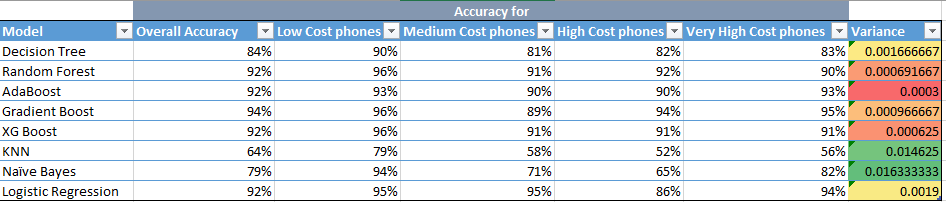

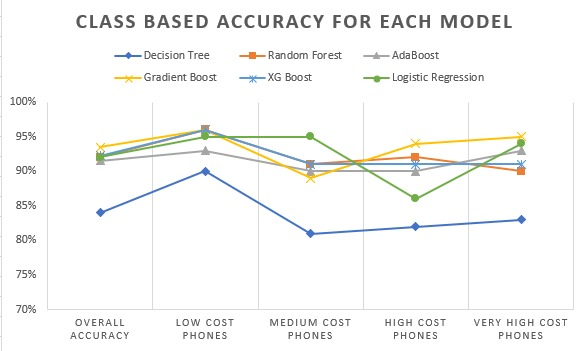

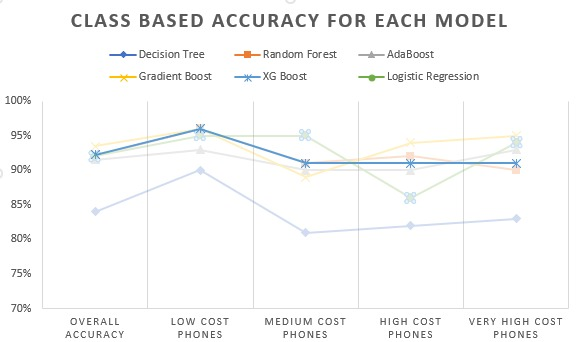

We tried multiple models and above table shows the summary for a set of models that we tried. 


*   Gradient Boost is giving us best overall 94% accuracy.
*   Random Forest and Adaboost and XG boost also giving 92% accuracy.

But we'll choose XG boost our best model, since it is giving good accuracy overall and as well as on indivisual clasees. You can see in the table that the variance for the class specific accuracy is lowest for XG boost.



After trying different models, the best features for mobile price range predictions are as follow:



1.   RAM
2.   Battery Power
3.   Mobile Weight
4.   Screen Size
5.   Pixels
6.   Talk Time
7.   Internal Memory

